In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib


In [3]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
df = pd.read_csv(r'C:\Users\LENOVO\OneDrive\Desktop\Historical Product Demand.csv')

In [5]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Data Understanding

In [6]:
df.shape

(1048575, 5)

In [7]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [8]:
df.Product_Code.unique()

array(['Product_0993', 'Product_0979', 'Product_1159', ...,
       'Product_0237', 'Product_0644', 'Product_0853'], dtype=object)

In [9]:
df.Warehouse.unique()

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [10]:
df.Product_Category.nunique()

33

# Data Cleaning

In [12]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [13]:
def check_order_demand(x):
    try:
        int(x)
    except:
        return False
    return True
#Check where Order_demand is not an integer
df[~df.Order_Demand.apply(lambda x: check_order_demand(x))].head(6)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
112290,Product_2169,Whse_A,Category_024,2012/8/9,(1)
112307,Product_2132,Whse_A,Category_009,2012/11/1,(24)
112308,Product_2144,Whse_A,Category_009,2012/11/1,(24)
112356,Product_2118,Whse_A,Category_009,2012/3/7,(50)
112357,Product_2120,Whse_A,Category_009,2012/3/7,(100)
112360,Product_1794,Whse_A,Category_024,2012/6/28,(1)


In [14]:
def change_to_int(x):
    try:
        return int(x)
    except:
        return int(x[1:-1])
check = '(10)'
change_to_int(check)

10

In [15]:
df.Order_Demand = df.Order_Demand.apply(lambda x: change_to_int(x) )

In [16]:
df.describe()

,Order_Demand
count,1.048575e+06
mean,4.906977e+03
std,2.892678e+04
min,0.000000e+00
25%,2.000000e+01
50%,3.000000e+02
75%,2.000000e+03
max,4.000000e+06


In [17]:
# Rename the columns
df = df.rename(columns = {'Product_Code': 'Code',
                    'Product_Category':'Category',
                    'Order_Demand':'Demand'})
df.head()

,Code,Warehouse,Category,Date,Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [18]:
# Check for missing data
df.isna().sum()

Code             0
Warehouse        0
Category         0
Date         11239
Demand           0
dtype: int64

In [19]:
100 * df.isna().sum()[3]/ df.shape[0]

1.0718355863910545

In [20]:
# 1% of the data has missing value so we can drop all the na
df = df.dropna()
df.isna().sum()

Code         0
Warehouse    0
Category     0
Date         0
Demand       0
dtype: int64

In [21]:
# Check the length of time the data was collected
df.Date.min(), df.Date.max()

('2011/1/8', '2017/1/9')

The data was collected from January 8th, 2011 to January 9th, 2017

In [22]:
df.Date.sort_values().unique()[:10]

array(['2011/1/8', '2011/10/20', '2011/10/31', '2011/11/18', '2011/11/21',
       '2011/11/22', '2011/11/23', '2011/11/24', '2011/11/25',
       '2011/11/28'], dtype=object)

In [23]:
# Set index to Date and Variable
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

<Axes: xlabel='Warehouse', ylabel='count'>

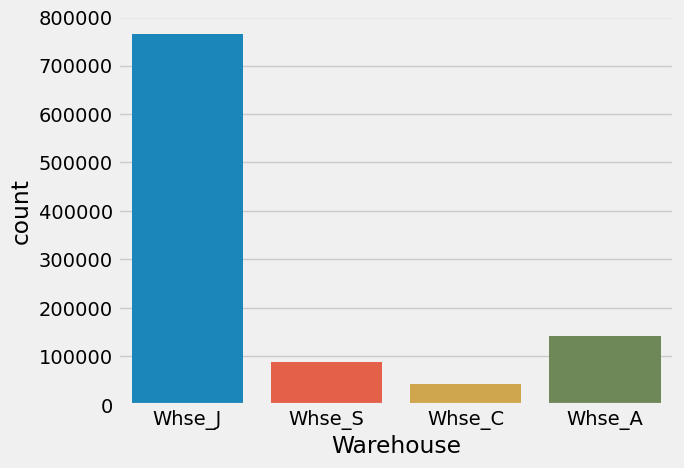

In [24]:
# Find the aggregate demand among the warehouses
sns.countplot(x = 'Warehouse', data = df)

 the above bar plot compares the count the numbers of orders by warehouses. Warehouses Whse_J has significantly more orders than the other warehouses with nearly 750,000 orders followed by Whse_A, then Whse_S and Whse_C

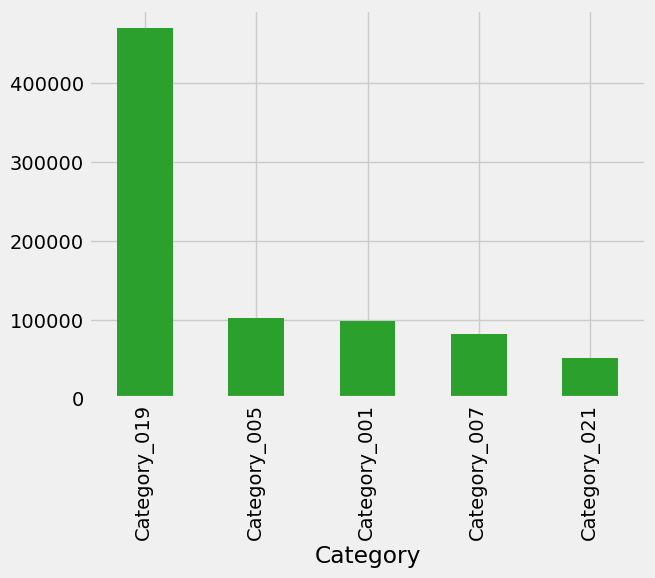

In [25]:
# Plot the 5 most popular category
df.Category.value_counts().head(5).plot(kind = 'bar', color = color_pal[2])
plt.xlabel('Category')
plt.show()

As shown on this plot, Category 019 ships by far the most orders in the product category

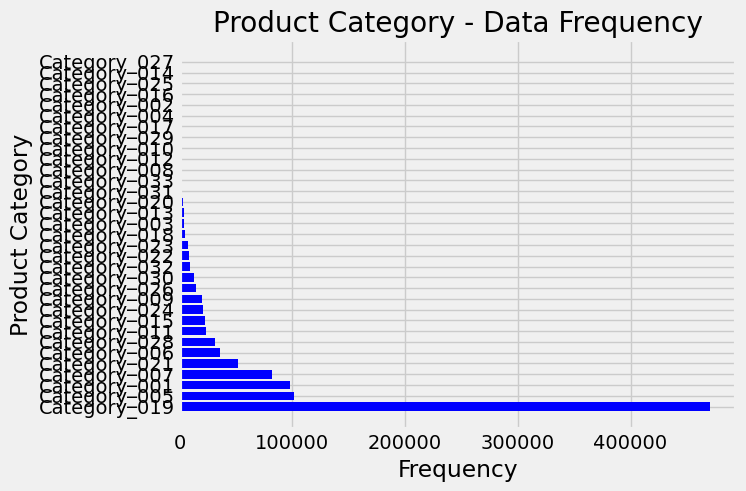

Number of ProductCategory 
Category
Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Category_006     35552
Category_028     31012
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14771
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: count, dtype: int64


In [40]:
# Number of samples according to ProductCategory
plt.figure()
plt.barh(df["Category"].value_counts().index, df["Category"].value_counts(), color = "b")
plt.xlabel("Frequency")
plt.ylabel("Product Category")
plt.title("Product Category - Data Frequency")
plt.show()
print(f"Number of ProductCategory \n{df['Category'].value_counts()}")

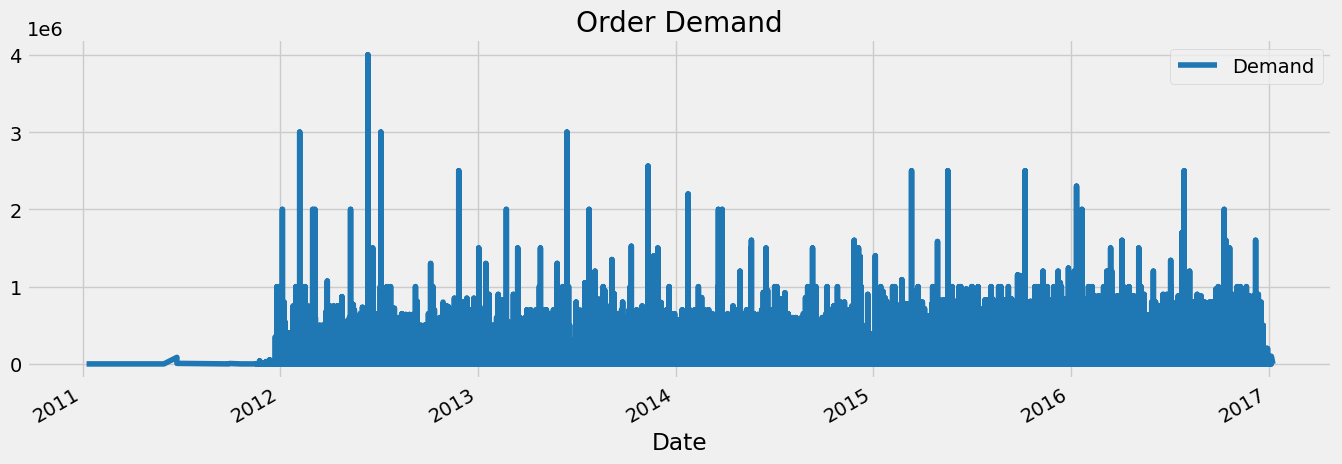

In [35]:
# Find the distribution of the demand
df.plot(kind = 'line',figsize=(15, 5),color = color_pal[0], title = 'Order Demand' )
plt.show()

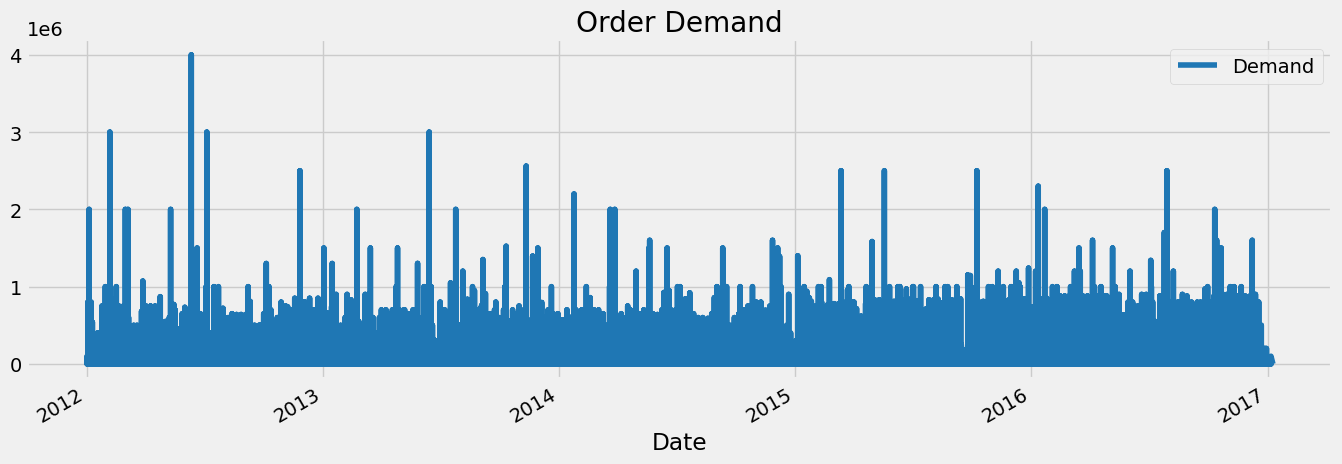

In [27]:
#This data have a lot of missing data before January 1st, 2012 
df_new = df.loc[df.index >= '01-01-2012']
df_new.plot(kind = 'line',figsize=(15, 5),color = color_pal[0], title = 'Order Demand' )
plt.show()

In [28]:
# Find the skewness in the data
df.Demand.skew()


31.432925049321977

# Bivariate Analysis/ Multivariate Analysis

In [29]:
# Total Demand by Warehouse
warehouse_Demand = df.groupby('Warehouse')['Demand'].sum()
warehouse_Demand

Warehouse
Whse_A     147877431
Whse_C     585071404
Whse_J    3363200396
Whse_S    1038024700
Name: Demand, dtype: int64

<Axes: ylabel='Sum of the demand'>

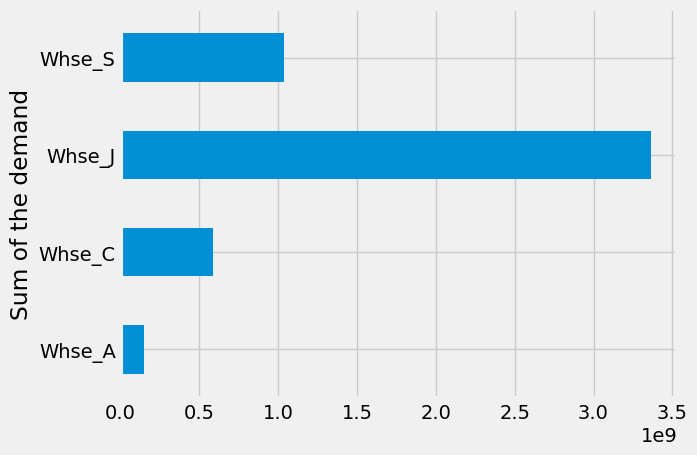

In [30]:
warehouse_Demand.plot(kind = 'barh', ylabel = 'Sum of the demand' )

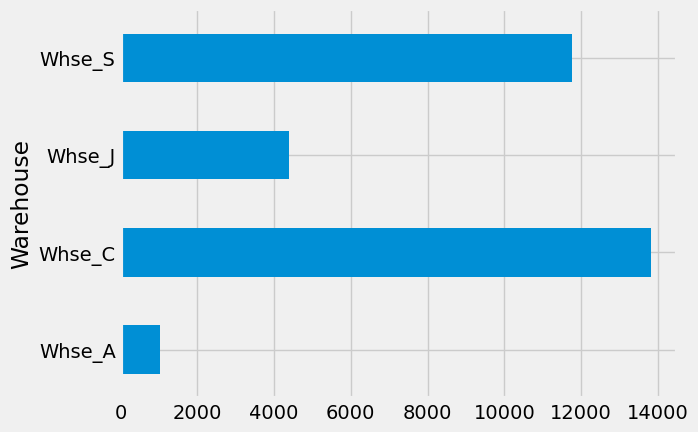

In [31]:
# Average Demand by Warehouse
df.groupby('Warehouse')['Demand'].mean().plot(kind = 'barh')
plt.show()

Although Warehouse Whse_J has the most orders, Whse_C and Whse_A shipped the most product per order on average. This can helpful when we want to reduce the cost of operation and shipping for instance.

In [32]:
df.head()

,Code,Warehouse,Category,Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500


In [33]:
import seaborn as sns

In [45]:
df.head(10)

,Code,Warehouse,Category,Demand,day_of_the_week,Quarter,Month,Year,Week
Date,,,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100,4,3,7,2012,30
2012-01-19,Product_0979,Whse_J,Category_028,500,3,1,1,2012,3
2012-02-03,Product_0979,Whse_J,Category_028,500,4,1,2,2012,5
2012-02-09,Product_0979,Whse_J,Category_028,500,3,1,2,2012,6
2012-03-02,Product_0979,Whse_J,Category_028,500,4,1,3,2012,9
2012-04-19,Product_0979,Whse_J,Category_028,500,3,2,4,2012,16
2012-06-05,Product_0979,Whse_J,Category_028,500,1,2,6,2012,23
2012-06-27,Product_0979,Whse_J,Category_028,500,2,2,6,2012,26
2012-07-23,Product_0979,Whse_J,Category_028,500,0,3,7,2012,30


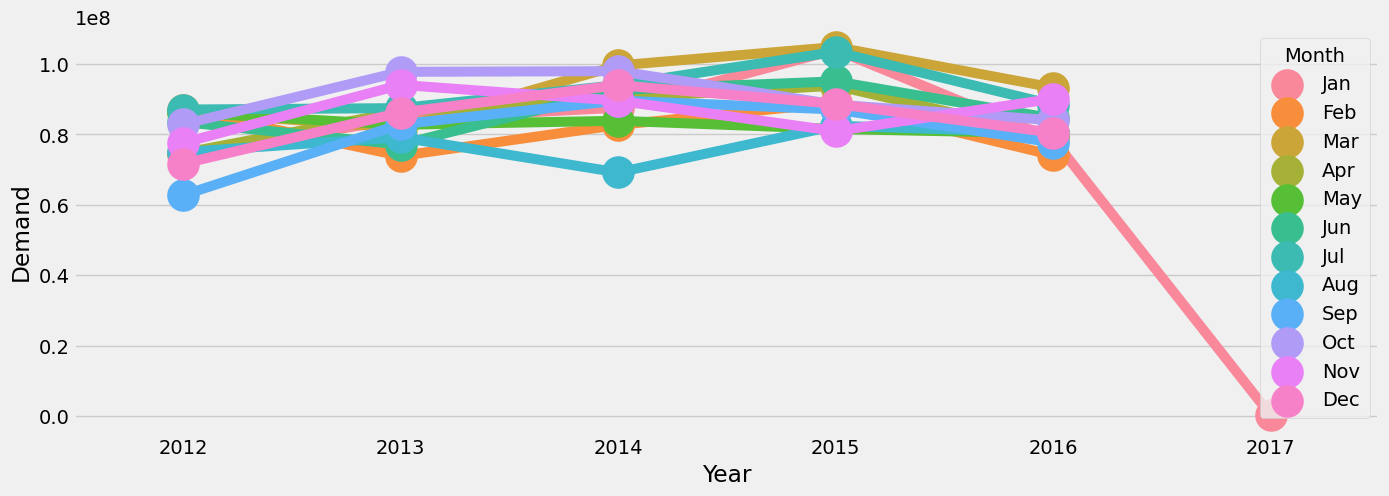

In [46]:
temp_data = df.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[['Demand','Month', 'Year',]].groupby(["Year","Month"]).sum().reset_index().sort_values(by=['Year','Month'], ascending=False)
f, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='Demand', data=df, hue='Month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

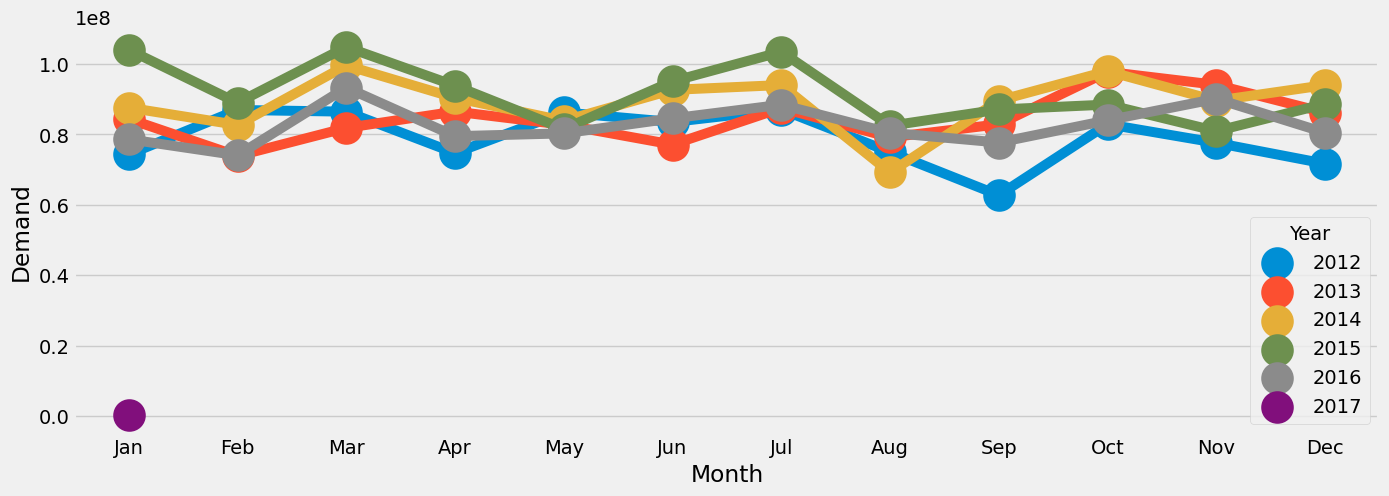

In [51]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
temp_data = df.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[["Demand", 'Month', 'Year']].groupby(["Year","Month"]).sum().reset_index().sort_values(by=['Year','Month'], ascending=True)
df = df.iloc[df['Month'].map(custom_dict).argsort()]
f, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(x='Month', y="Demand", data=df, hue="Year")
plt.show()

In [55]:
Features = ['day_of_the_week', 'Quarter','Month', 'Year', 'Week']
target = ['Demand']

# Feature Engineering

In [58]:
def create_feature(dataframe):
    dataframe = dataframe.copy()
    dataframe['day_of_the_week'] = dataframe.index.dayofweek
    dataframe['Quarter'] = dataframe.index.quarter
    dataframe['Month'] = dataframe.index.month
    dataframe['Year'] = dataframe.index.year
    dataframe['Week'] = dataframe.index.isocalendar().week.astype(int)
    return dataframe

df = create_feature(df_new)
df.dtypes

Code               object
Warehouse          object
Category           object
Demand              int64
day_of_the_week     int32
Quarter             int32
Month               int32
Year                int32
Week                int32
dtype: object

In [59]:
# features, Target variable
Features = ['day_of_the_week', 'Quarter','Month', 'Year', 'Week']
target = ['Demand']

# Create our model using XGboost

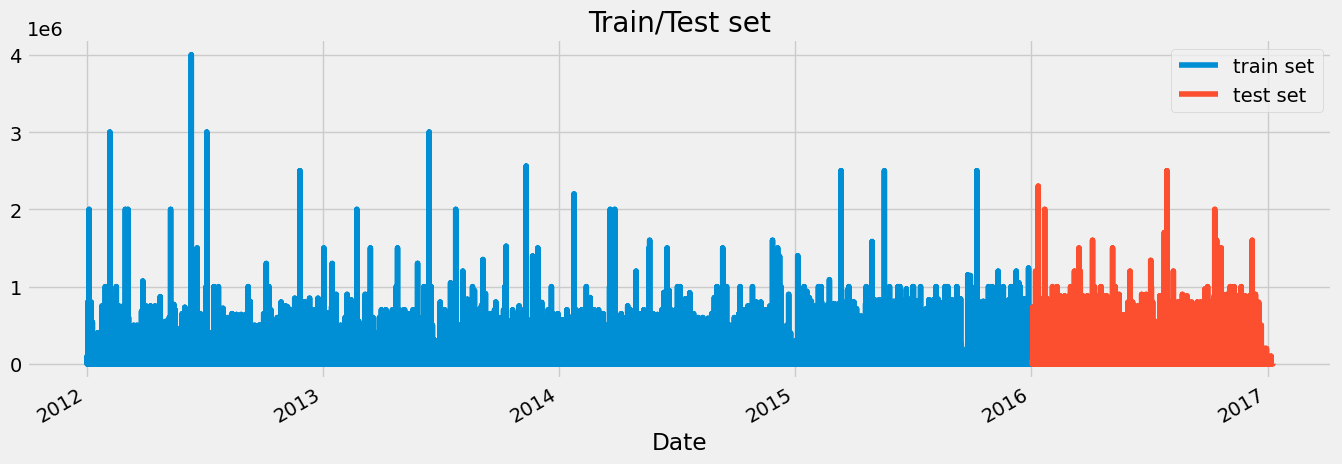

In [61]:
# Split the data in Train/ Test set
df_train = df.loc[df.index <= '2016-01-01'].copy()
df_test = df.loc[df.index > '2016-01-01'].copy()

#plot train/test
fig, ax = plt.subplots(figsize = (15,5))
df_train.Demand.plot(ax = ax, label = 'train set',legend = 'train set', title = 'Train/Test set')
df_test.Demand.plot(ax = ax, legend = 'train set', label = 'test set')
plt.show()

In [62]:
#Split the data into training set and testing set 
X_train = df_train[Features]
X_test = df_test[Features]

y_train = df_train[target]
y_test = df_test[target]

In [65]:
! pip install xgboost

In [66]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 1000,
                    early_stopping_rounds = 50,
                    learning_rate = 0.01).fit(X_train, y_train,
                                                   eval_set = [(X_train,y_train), (X_test,y_test)],
                                                   verbose = 50)

[0]	validation_0-rmse:28618.31468	validation_1-rmse:30762.61958
[50]	validation_0-rmse:28602.60800	validation_1-rmse:30751.44447
[100]	validation_0-rmse:28595.41920	validation_1-rmse:30748.08317
[150]	validation_0-rmse:28590.39512	validation_1-rmse:30747.91228
[178]	validation_0-rmse:28588.35406	validation_1-rmse:30749.21684


Model stopped after 178 trees because our validation rmse start to go up (overfitting)

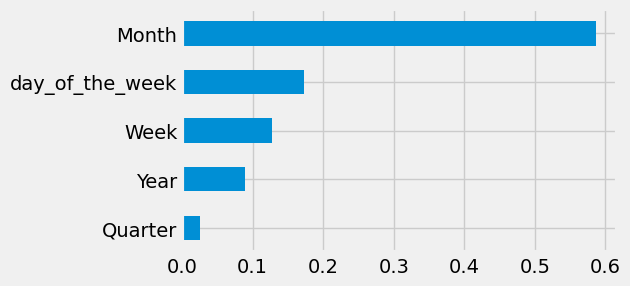

In [67]:
# Features Importance
fea_Imp = pd.DataFrame(model.feature_importances_, index = Features, columns = ['feature_importance'])
#plot the features importance
fea_Imp.feature_importance.sort_values().plot(kind = 'barh', figsize =(5,3))
plt.show()

In [68]:
df_test['prediction'] = model.predict(X_test)

In [69]:
df_test['prediction']

Date
2016-01-28    4967.443359
2016-01-04    6975.097168
2016-01-06    6691.881348
2016-01-06    6691.881348
2016-01-06    6691.881348
                 ...     
2016-04-27    4611.945312
2016-04-27    4611.945312
2016-04-28    4919.939453
2016-10-07    4766.686523
2016-06-27    5659.013184
Name: prediction, Length: 188698, dtype: float32

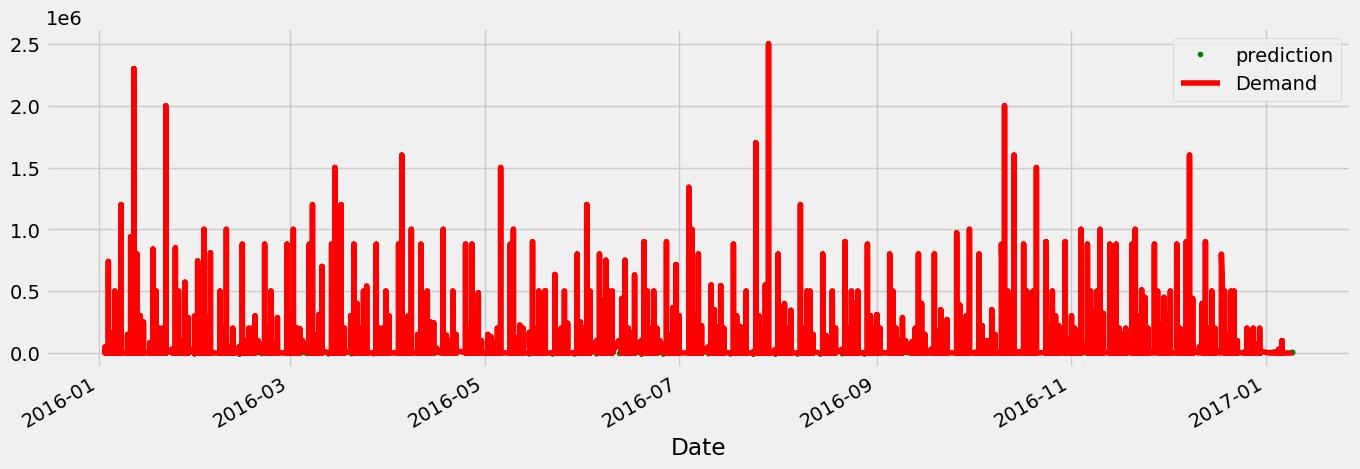

In [70]:
fig, ax = plt.subplots( figsize = (15,5))
df_test.prediction.plot(ax = ax, color = 'g', style = '.', legend = 'Prediction')
df_test.Demand.plot(ax = ax, color = 'r', legend = 'Testing')
plt.show()

We barely can see the prediction, XGboost did really bad at capturing the trend and seasonlity in the data. Let's use a more robust machine learning technique

# Time Series Analysis

Time series analysis is a specific way of analyzing a sequence of data points collected over an interval of time. In time series analysis, analysts record data points at consistent intervals over a set period of time rather than just recording the data points intermittently or randomly.

# Visualise Features/ Target Relationship

In [73]:
# Resample data as Weekly 
df_week = df.resample('W').mean(numeric_only=True)
df_week

,Demand,day_of_the_week,Quarter,Month,Year,Week
Date,,,,,,
2012-01-01,2.000000,6.000000,1.0,1.0,2012.0,52.0
2012-01-08,7284.227771,3.186358,1.0,1.0,2012.0,1.0
2012-01-15,4444.277167,2.355514,1.0,1.0,2012.0,2.0
2012-01-22,4115.208970,1.966424,1.0,1.0,2012.0,3.0
2012-01-29,3597.824067,1.842063,1.0,1.0,2012.0,4.0
...,...,...,...,...,...,...
2016-12-18,4915.856120,1.991362,4.0,12.0,2016.0,50.0
2016-12-25,5559.653308,1.576336,4.0,12.0,2016.0,51.0
2017-01-01,5578.072760,1.031870,4.0,12.0,2016.0,52.0


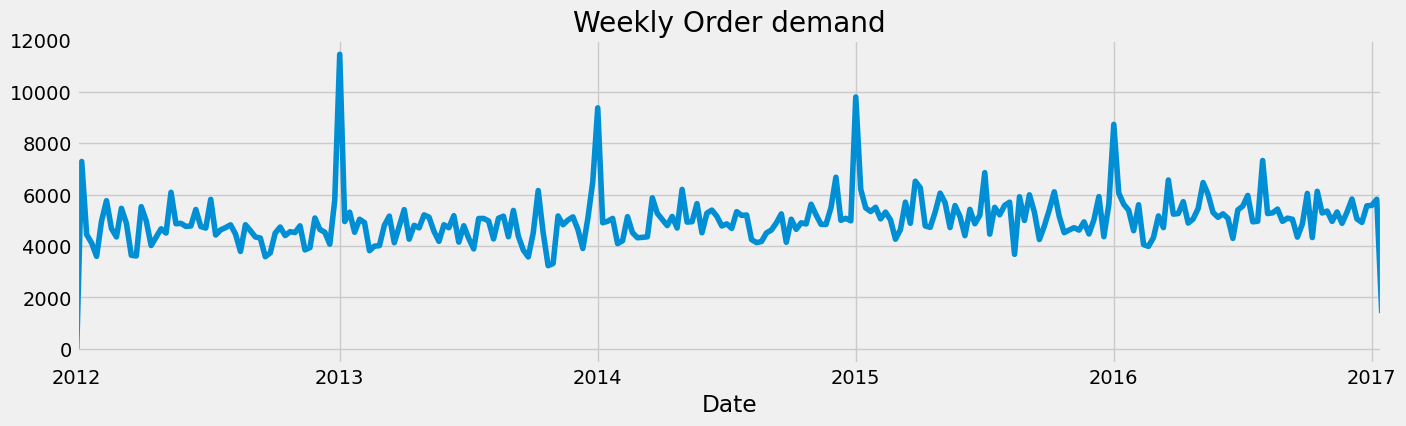

In [74]:
df_week['Demand'].plot(figsize = (15,4), title = 'Weekly Order demand')
plt.show()

These data show a seasonal pattern. The pattern repeats every 12 months. The demand increase in December(probably due to the holiday season) and decrease probably in January.
I can see a pattern in the weekly order demand, Let's explore the monthly pattern by sampling the data monthly

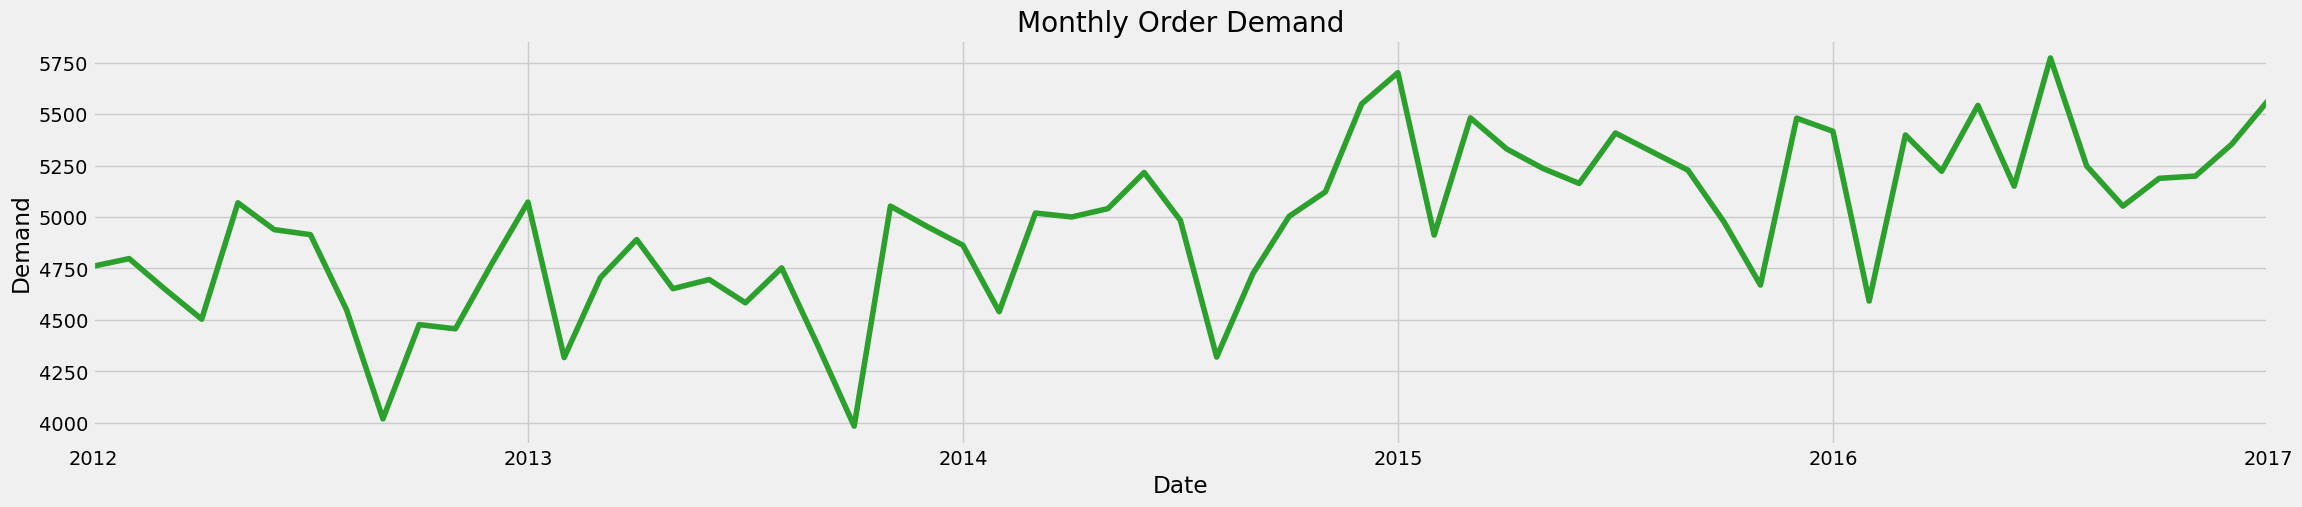

In [75]:
df_month = df.resample('MS').mean(numeric_only=True)
df_month.Demand.plot(figsize = (25,5), title = 'Monthly Order Demand', color = color_pal[2])
plt.ylabel('Demand')
plt.show()

This plot shows a clear upward trend from the last quarter of 2013 to the beginning of 2017...

# Decomposition to check the seasonality, trends and residuals.

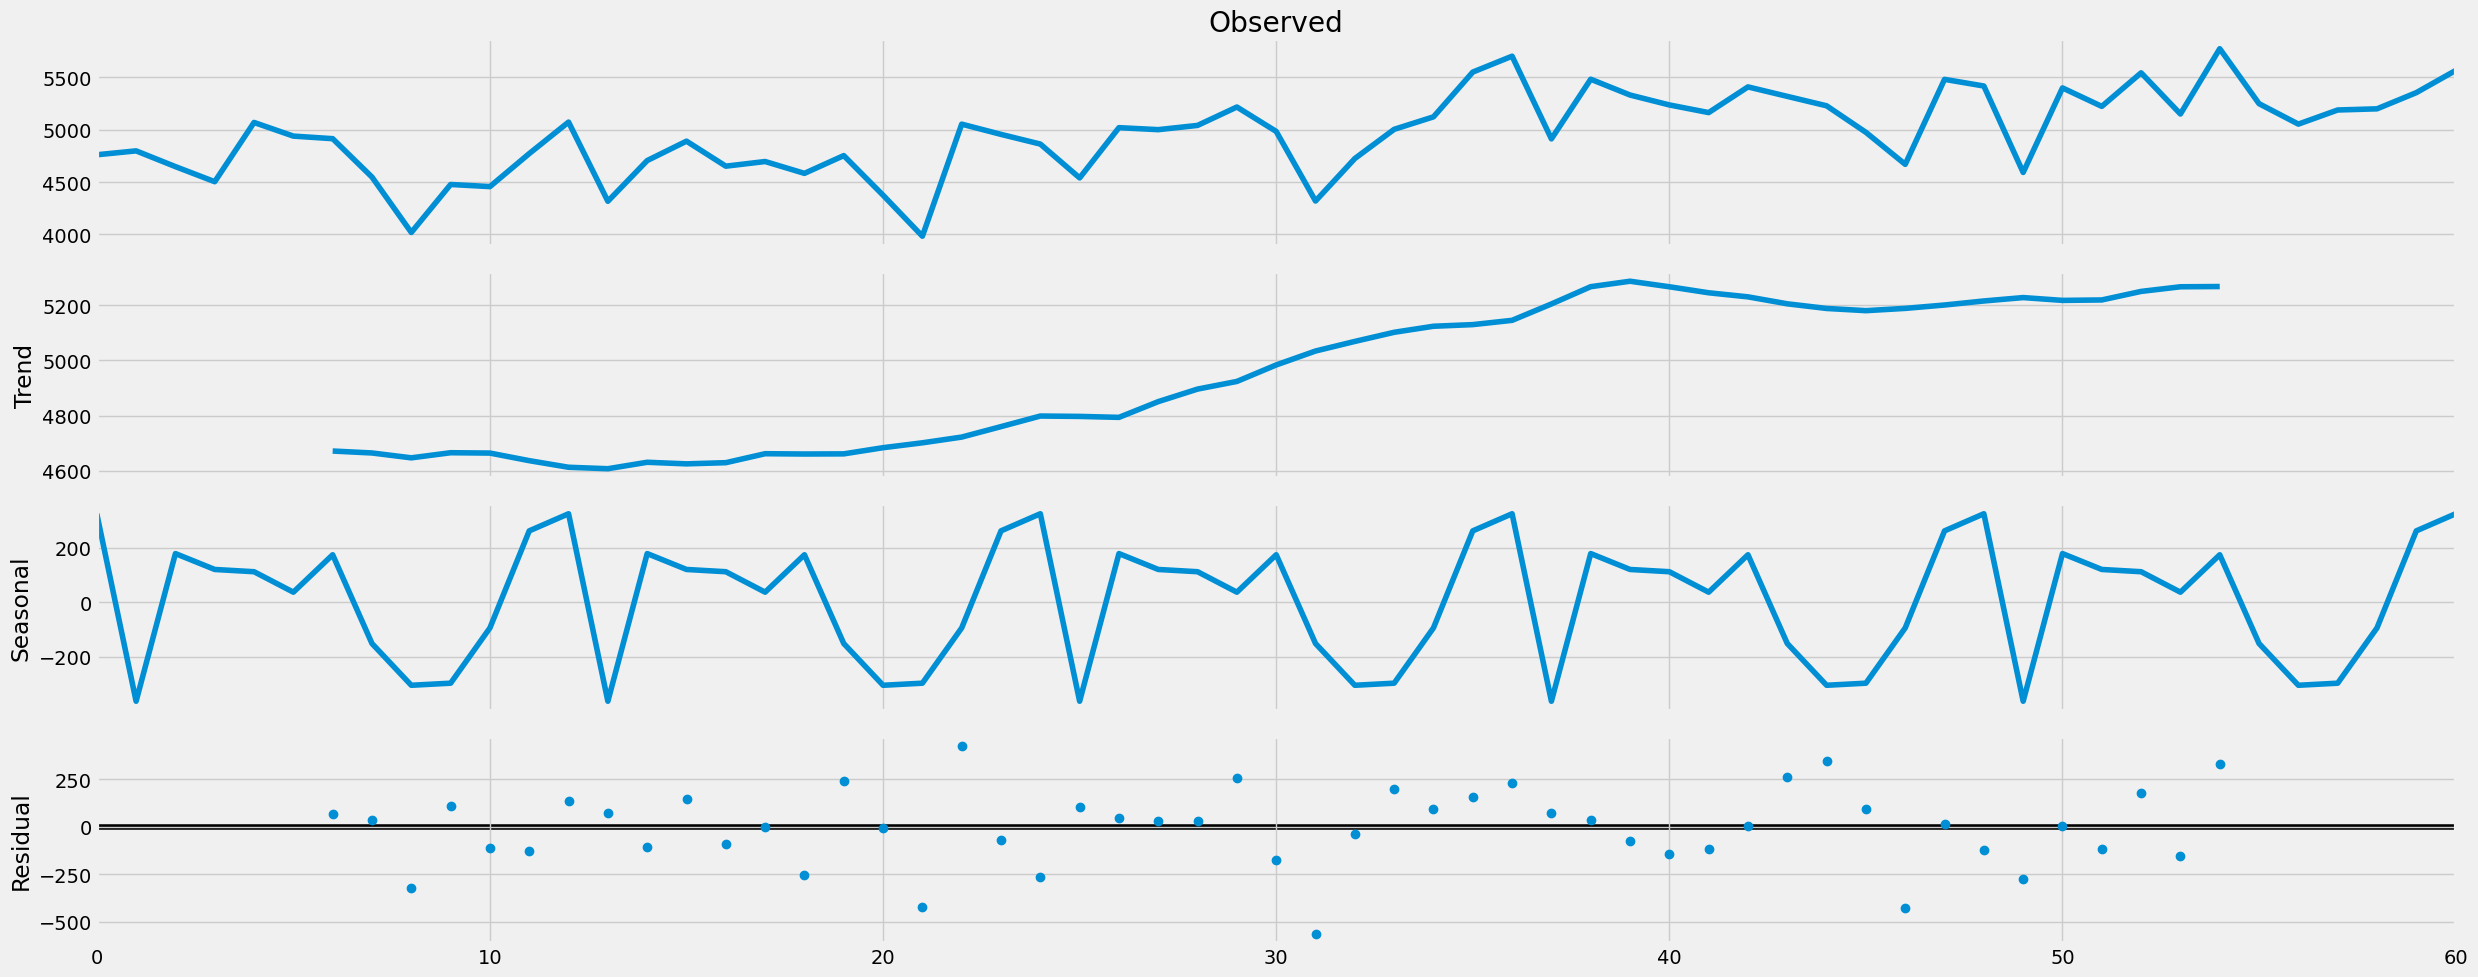

In [76]:
#Seasonal decomposition using moving averages
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 25, 10
decomposition = seasonal_decompose(df_month.Demand.values, model='additive', period = 12)
                   
fig = decomposition.plot()
plt.show()

# Visually, the time series is non-stationary but I will perform the Augmented Dickey- Adfuller test (ADF) to make sure of that

In [77]:
# import stats libraries
from statsmodels.tsa.stattools import adfuller
adfuller(df_month['Demand'])

(-2.1353562491537064,
 0.23053730809929168,
 2,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 714.3239865088049)

1)The p-value is obtained is greater than significance level of 0.05
2)Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

# Make Series Stationnary

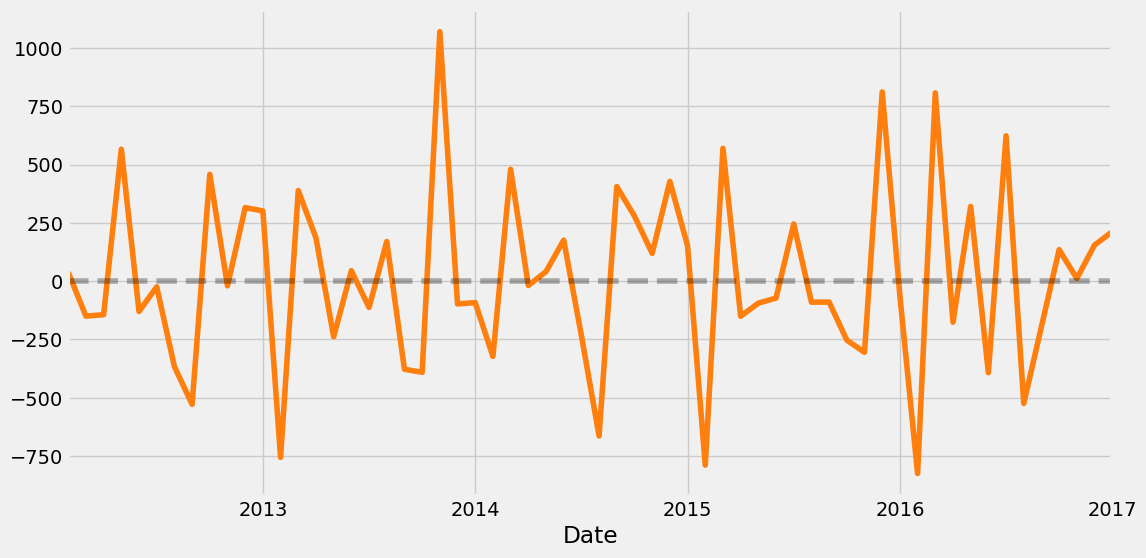

In [78]:
# Take First Difference to Remove Trend
df_diff = df_month.Demand.diff()[1:]
df_diff.plot(figsize=(12,6), color = color_pal[1])
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

In [79]:
# Augmented Dicker Fuller Test to check if this new series is stationnary after differentiation
adfuller(df_diff)

(-6.758687705873296,
 2.8284296959133446e-09,
 2,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 700.6632081217224)

The p-value is less than 0.05 so data series is stationnary

# Build ARIMA Model

<ul>
    <li>ARIMA models are generally denoted as ARIMA (p,d,q) where:</li>
    <li>p is the order of autoregressive model (Forecasts future behavior based on past behavior data)</li>
    <li>d is the degree of differencing(Integrating or eleminate trend in the data)</li>
    <li>and q is the order of moving-average model(Past errors to predict the future)</li>
    <li>ARIMA models use differencing to convert a non-stationary time series into a stationary one, and then predict future values from historical data.</li>
    <li>Ways to determine p,q,d:</li>
    <li>Using ACF And PCAF plots to find p,q and d is how many times we differenciate the data</li>
    <li>Auto_Arima function tries different orders and determine the best model based on AIC criteria(lowest AIC)</li>
    <li>For Loop</li>
    </ul>

### 1) ACF and PACF plots and Interpretation

In [81]:
# Import libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

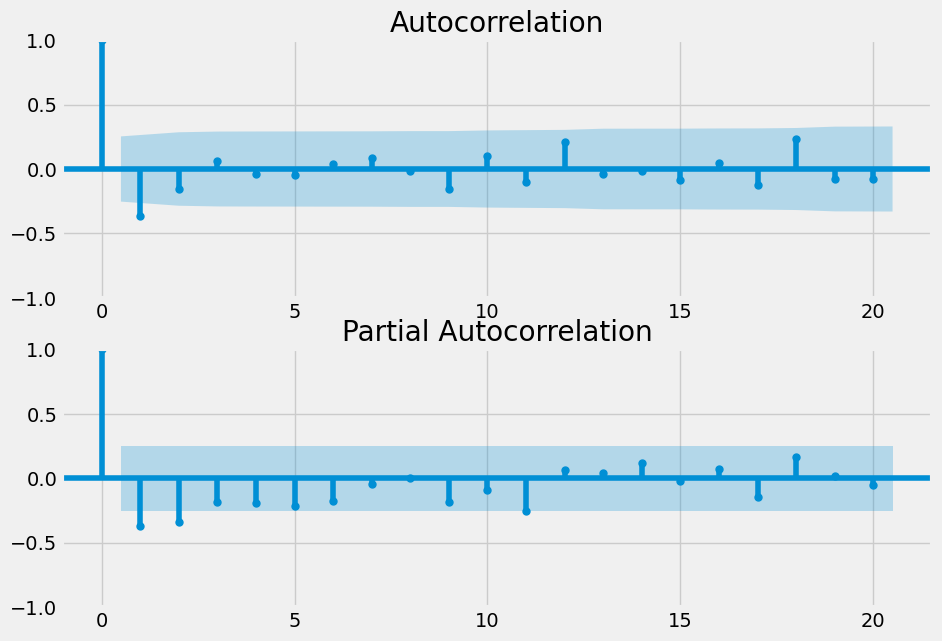

In [82]:
# plot ACF
fig = plt.figure(figsize = (10,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_diff, lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_diff, lags = 20, method='ywm', ax = ax2)
plt.show()

Based on the AutoCorrelation chart:
    <li>Lag 1 is strong(cross the Confidence Interval) so the order of q is 1</li>
    <li>Based on the Partial AutoCorrelation chart, Lag 1 and 2 are strong(cross the Confidence Interval) so the order of p is 2</li>
    <li>I differentiate only once to make the series stationnary so d is 1</li>

### 2) Train / Test split

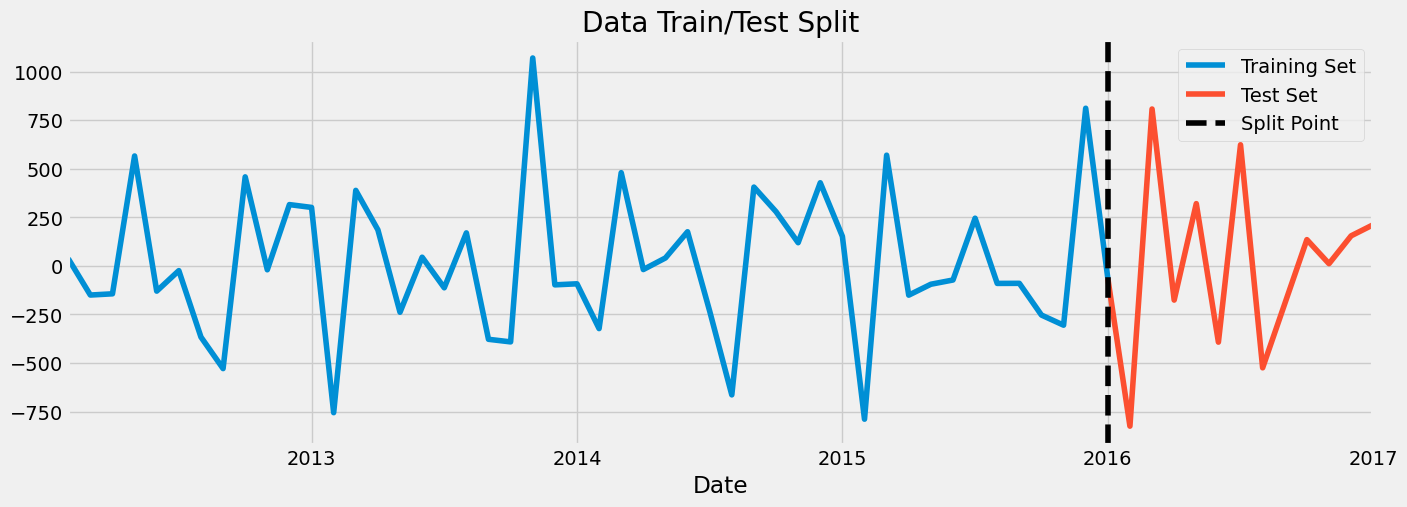

In [84]:
from datetime import datetime
from datetime import timedelta
train_end = datetime(2016,1,1)
test_end = datetime(2017,1,1)

df_train = df_diff[:train_end]
df_test = df_diff[train_end:test_end]

# plot train and test dataset on the same graph
fig, ax = plt.subplots(figsize=(15, 5))
df_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set','Split Point'])
plt.show()

### 3) Import Libraries and fit the model

In [85]:
# Fit the model
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(df_train, order = (2,1,1)).fit()

In [86]:
# summary of the model
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                   48
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -343.242
Date:                Mon, 18 Mar 2024   AIC                            694.484
Time:                        19:22:06   BIC                            701.885
Sample:                    02-01-2012   HQIC                           697.269
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3710      0.168     -2.211      0.027      -0.700      -0.042
ar.L2         -0.3259      0.184     -1.768      0.077      -0.687       0.035
ma.L1         -0.9999      0.252     -3.964      0.0

Based on the summary:
- The values of the coefficients for AR lag1, lag2 and MA lag1 are negatives which indicates that the time series 
current period is negatively correlated with the time series at those lags
-The p values for AR lag 1 and MA lag 1, sigma2 are significants because it is below 0.05

In [87]:
# get the predictions start and end dates
pred_start = df_test.index[0]
pred_end= df_test.index[-1]

# Make predictions
prediction = model_arima.predict(start = pred_start, end = pred_end)

# Get the residuals
residuals = df_test - prediction

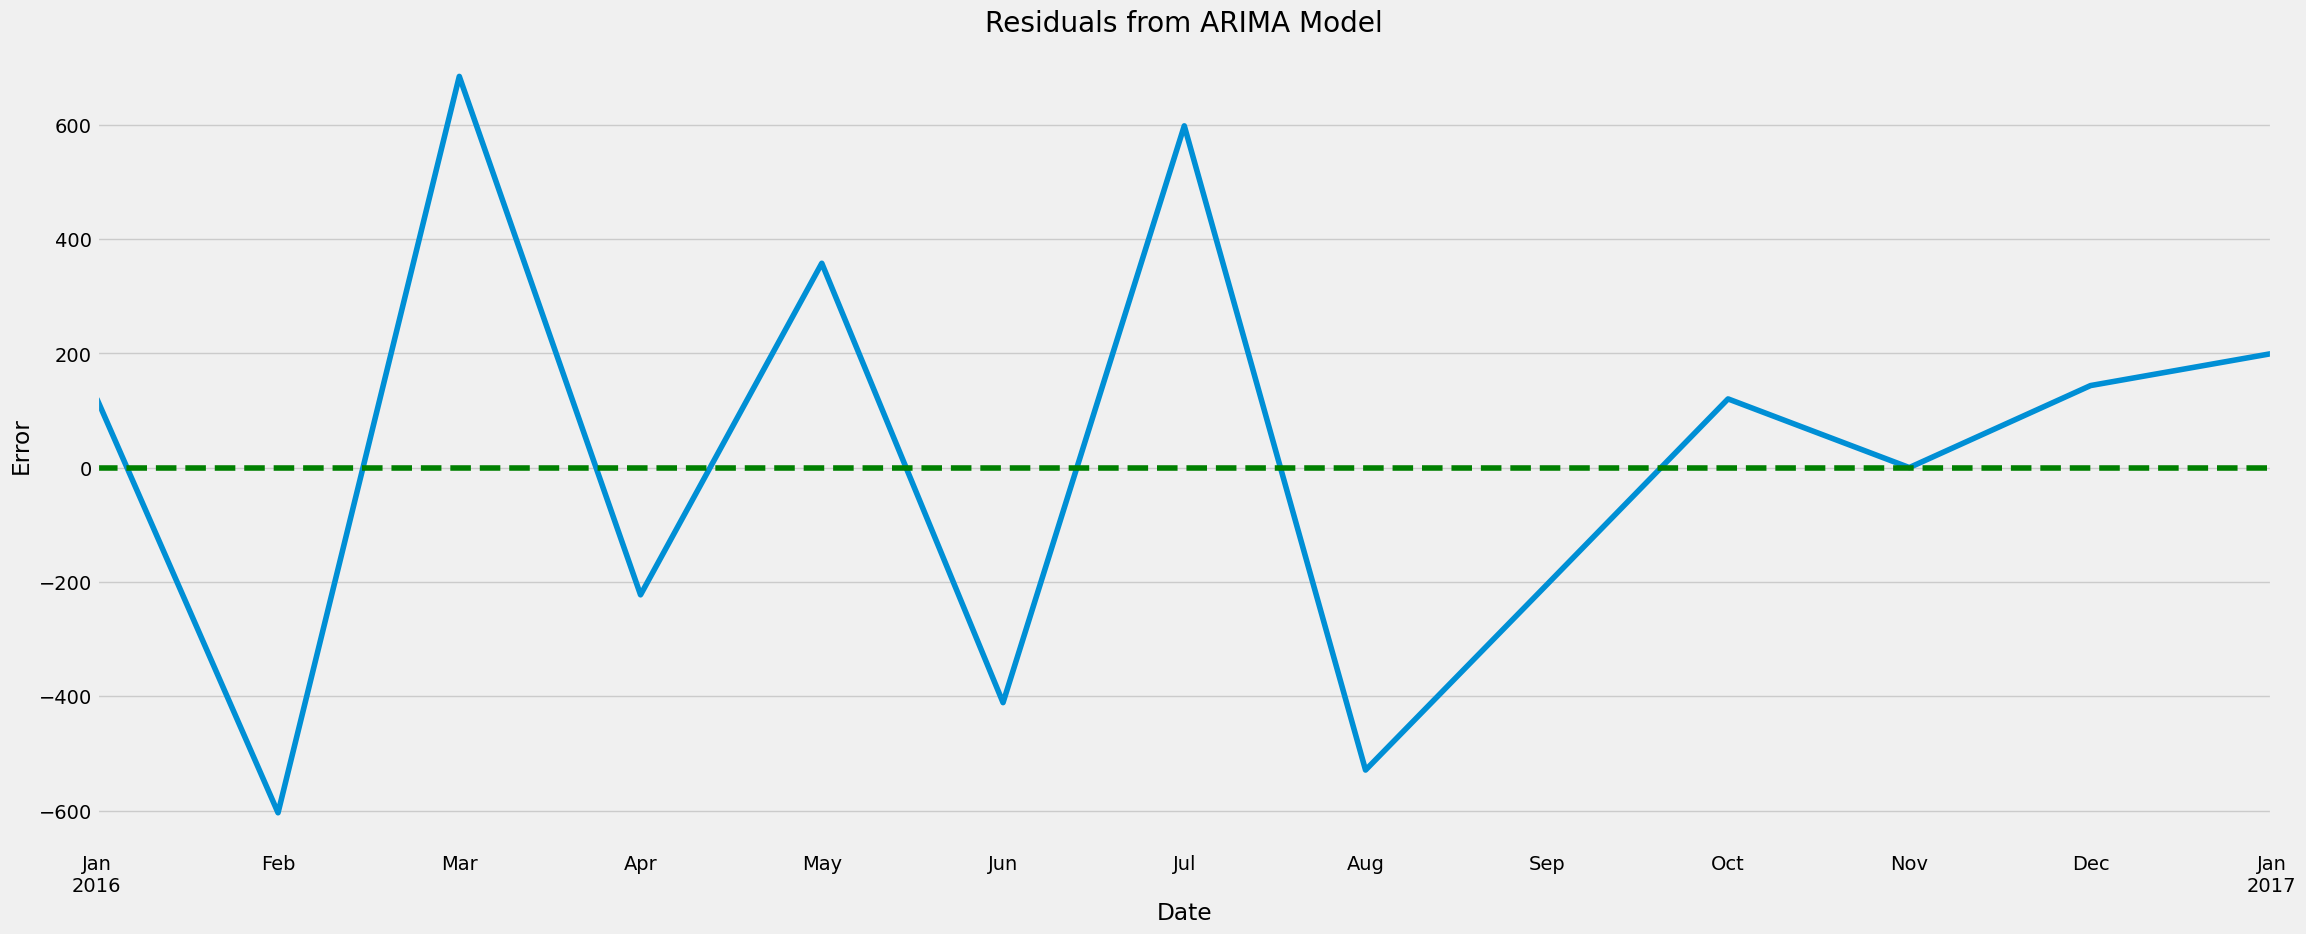

In [89]:
# Plot the residuals
residuals.plot(kind = 'line', title = 'Residuals from ARIMA Model')
plt.axhline(0,color ='g', linestyle = '--')
plt.ylabel('Error')
plt.show()

In [90]:
# Get the Root Mean Square Error
rmse = np.sqrt(np.mean(residuals**2))
rmse

387.30403267858975

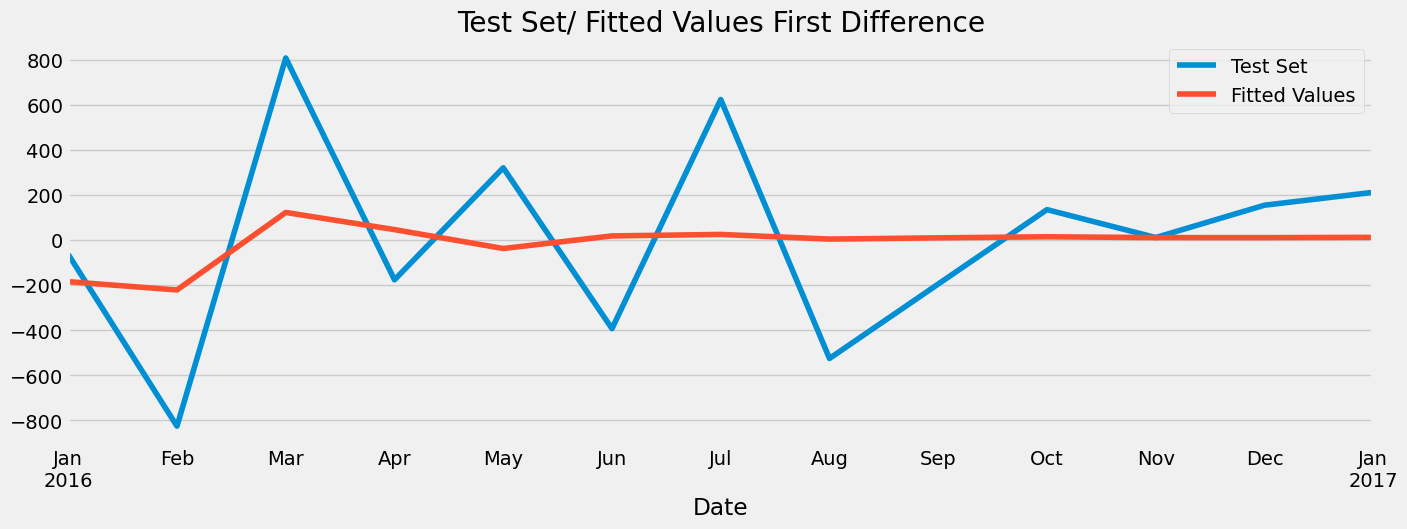

In [91]:
# Plot the train set against the predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_test.plot(ax=ax, label='Training Set', title='Test Set/ Fitted Values First Difference')
prediction.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Fitted Values'])
plt.show()

# Sarima model to capture seasonality

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima =SARIMAX(df_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
print(model_sarima.summary().tables[1])
pred = model_sarima.predict(start = pred_start, end = pred_end)

C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2929      0.232     -1.263      0.207      -0.748       0.162
ma.L1         -1.0000      9.961     -0.100      0.920     -20.523      18.523
ar.S.L12      -0.0811      0.380     -0.213      0.831      -0.826       0.664
ma.S.L12      -1.0503      9.499     -0.111      0.912     -19.668      17.567
sigma2      8.553e+04      0.000   6.89e+08      0.000    8.55e+04    8.55e+04


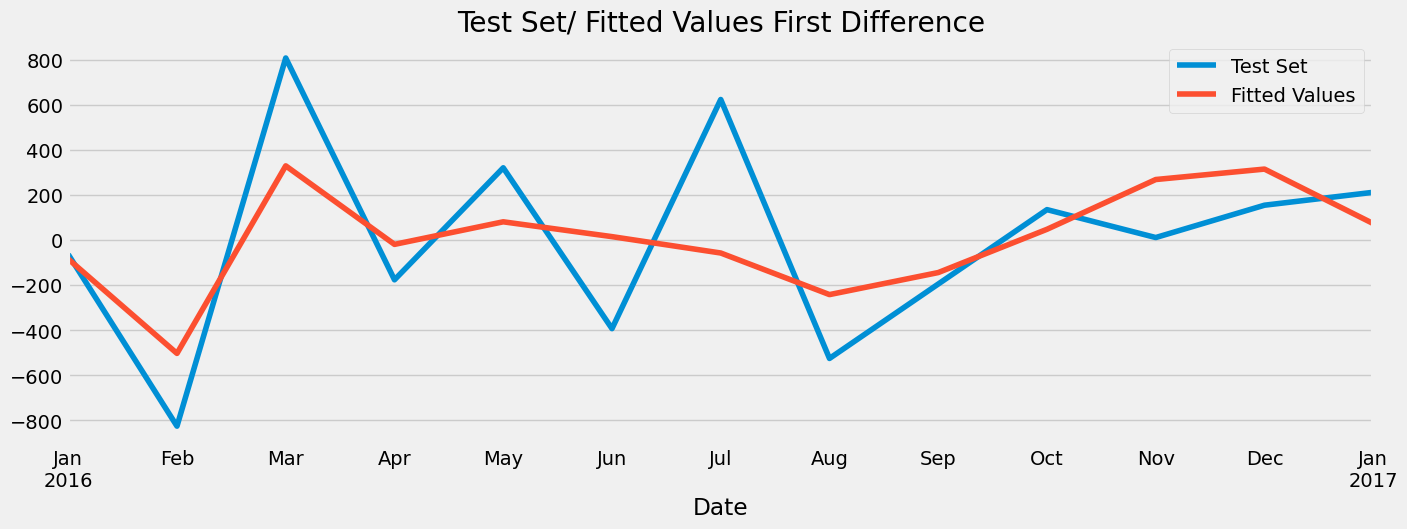

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
df_test.plot(ax=ax, label='Training Set', title='Test Set/ Fitted Values First Difference')
pred.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Fitted Values'])
plt.show()

In [95]:
# Root Mean Square
res = df_test - pred
rmse = np.sqrt(np.mean(res**2))
rmse

309.6197257642476

# Taking Results back to original scale¶

In [96]:
# Getting only the value of zeroth index since the diff() operation looses first value.
pred.iloc[0] = df_month.query('index == "2016-01-01"')['Demand']
#cumsum Return cumulative sum over a DataFrame or Series axis
model_predicted = pred.cumsum()
model_predicted.head()

2016-01-01    5416.990630
2016-02-01    4914.334262
2016-03-01    5243.311593
2016-04-01    5224.125934
2016-05-01    5304.983633
Freq: MS, Name: predicted_mean, dtype: float64

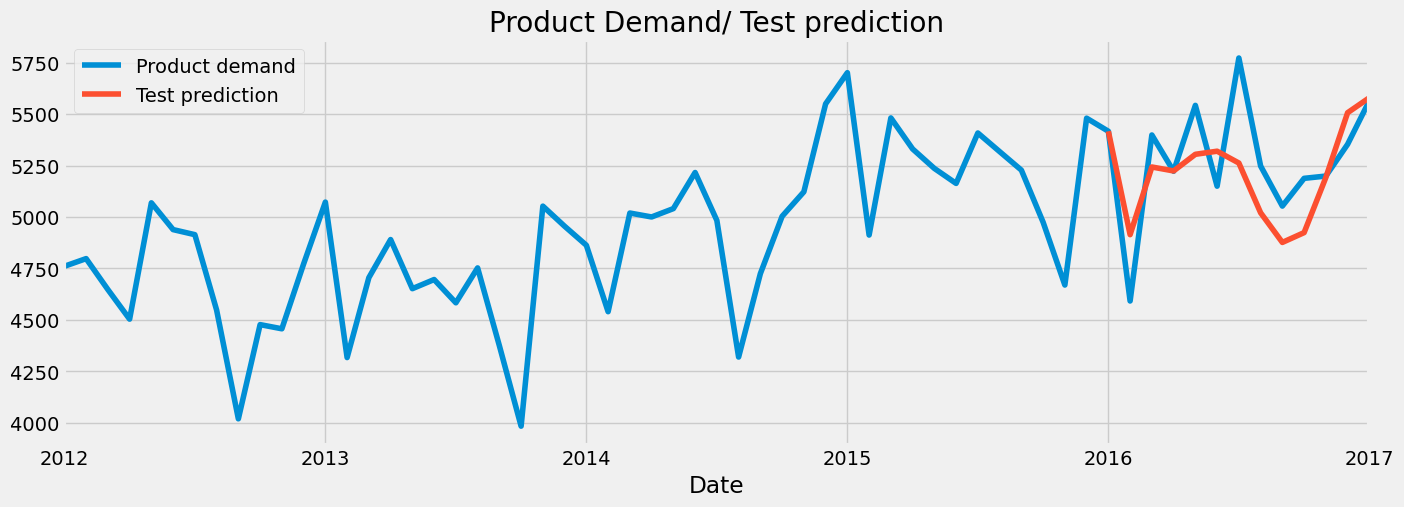

In [97]:
# Plot the actual data set and the actual predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_month.Demand.plot(ax=ax, label='Product Demand', title='Product Demand/ Test prediction')
model_predicted.plot(ax=ax, label='Test prediction')
ax.legend(['Product demand', 'Test prediction'])
plt.show()

# Future Prediction

In [99]:
# predict Demand for the next year
future = model_sarima.predict(start = '2017-01-01', end = '2017-12-01')
# Getting only the value of zeroth index since the diff() operation looses first value.
future.iloc[0] = df_month.query('index == "2017-01-01"')['Demand']
#cumsum Return cumulative sum over a DataFrame or Series axis
future = future.cumsum()

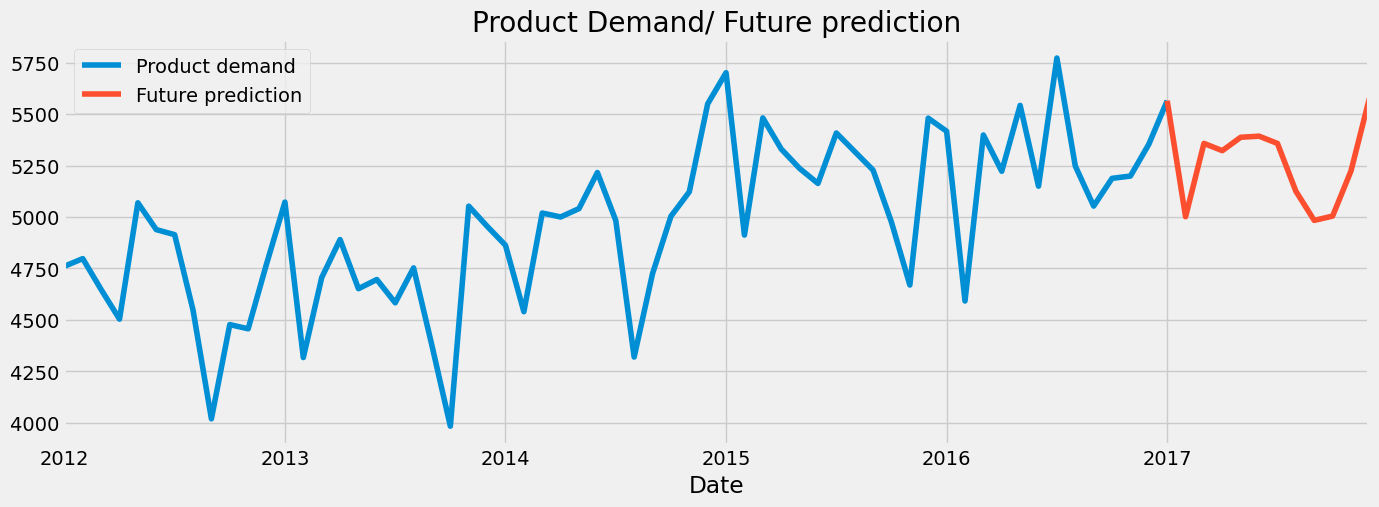

In [100]:
fig, ax = plt.subplots(figsize=(15, 5))
df_month.Demand.plot(ax=ax, label='Product Demand', title='Product Demand/ Future prediction')
future.plot(ax=ax, label='Future')
ax.legend(['Product demand', 'Future prediction'])
plt.show()

In [106]:
import joblib
joblib.dump(model_sarima, 'finalized_model.sav')

['finalized_model.sav']